In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import time
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("C:/Users/oekpom/Desktop/Datasets/Machine Learning/Lesson 8/zinc_prices_IMF.csv")

In [3]:
data.head()

,Date,Price
0,1-Jan-80,773.82
1,1-Feb-80,868.62
2,1-Mar-80,740.75
3,1-Apr-80,707.68
4,1-May-80,701.07


In [4]:
data["Date"] = data["Date"].apply(lambda x: time.strptime(x, "%d-%b-%y"))
data["Date"] = data["Date"].apply(lambda x: dt(int(x[0]), int(x[1]),int(x[2])))
data = data.set_index("Date")
data.head()

,Price
Date,
1980-01-01,773.82
1980-02-01,868.62
1980-03-01,740.75
1980-04-01,707.68
1980-05-01,701.07


In [5]:
ts = data["Price"]

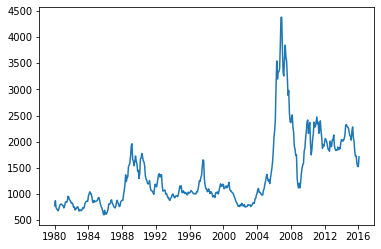

In [6]:
plt.plot(ts)

In [7]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center=False).std()
    
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard deviation")
    plt.show(block=False)
    
    print("Results of Dickey-Fuller test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" %key] = value
    print(dfoutput)

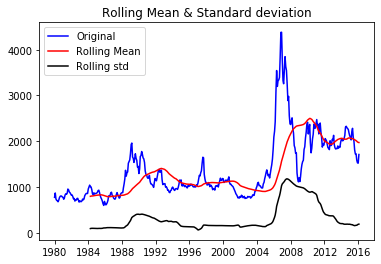

Results of Dickey-Fuller test:
Test Statistic                  -3.139601
p-value                          0.023758
#Lags Used                       7.000000
Number of Observations Used    426.000000
Critical Value (1%)             -3.445794
Critical Value (5%)             -2.868349
Critical Value (10%)            -2.570397
dtype: float64


In [8]:
test_stationarity(data["Price"])
#the Test Statistic of -3.139601 is less than the Critical Value (5%) of -2.868349 so the data is not stationary

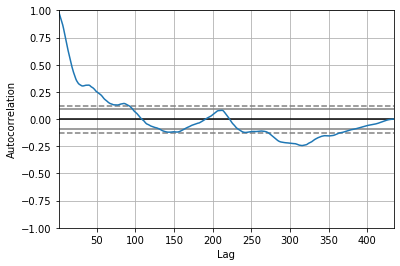

In [9]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts)

In [11]:
pacf(ts)

array([ 1.        ,  0.98690163, -0.32241017,  0.0789833 ,  0.02616115,
       -0.05610838, -0.1396181 , -0.12229695, -0.14944739,  0.0579308 ,
       -0.04348724, -0.00445095, -0.00187066,  0.0515694 ,  0.11603736,
       -0.02719553, -0.1297157 ,  0.09553807, -0.0153863 ,  0.0110505 ,
        0.04630165, -0.00865825,  0.01796687,  0.05281257,  0.06878575,
        0.06486562, -0.03087404,  0.07355673,  0.08020754, -0.07676689,
       -0.06631524,  0.0421765 ,  0.07275367, -0.03960838,  0.03152856,
       -0.04679625,  0.04008641, -0.05073331,  0.02572135, -0.05762724,
       -0.04328533])

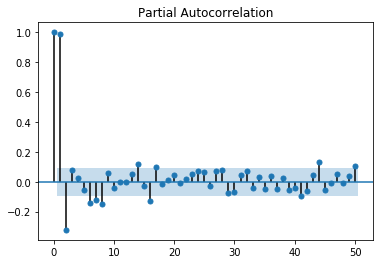

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ts, lags=50)
plt.show()

In [15]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [17]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7576.810993322944
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6939.228206706223
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6503.516893521912
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6326.163799632652
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6512.717644249548
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6500.412571638081
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6345.145360649374
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6318.7229742464115
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6992.514336817669
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6404.187498883438
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:5993.705629699505
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5822.968428226133
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6014.375117630526
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5986.095038123426
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:5859.397614011545
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5833.2796407276055
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5320.990494720091
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5184.867235343952
ARIMA(0,

Text(0.5, 1.0, 'RSS: nan')

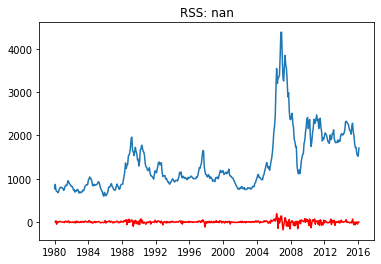

In [24]:
model = ARIMA(ts, order=(0, 1, 1))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts)
plt.plot(results_ARIMA.fittedvalues, color="red")
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues[1:] - ts)**2))

In [32]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
1980-02-01     2.406350
1980-03-01    29.974577
1980-04-01   -49.293824
1980-05-01     7.771521
1980-06-01    -2.354549
dtype: float64

In [33]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
1980-02-01     2.406350
1980-03-01    32.380927
1980-04-01   -16.912897
1980-05-01    -9.141376
1980-06-01   -11.495925
dtype: float64

In [35]:
ts_log = np.log(ts)
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Date
1980-01-01     6.651339
1980-02-01     9.057690
1980-03-01    39.032267
1980-04-01   -10.261558
1980-05-01    -2.490037
dtype: float64

Text(0.5, 1.0, 'RMSE: inf')

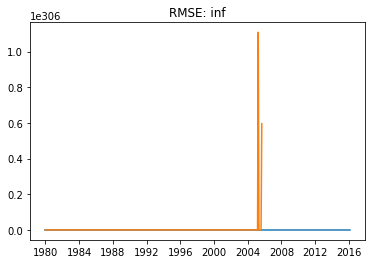

In [36]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((predictions_ARIMA - ts)**2)/len(ts)))